# HW5: Topic Models and LDA


**STATS271/371: Applied Bayesian Statistics**

_Stanford University. Spring, 2021._

---

**Name:** Isaac Kleisle-Murphy

**Names of any collaborators:** Anmol, Yan

*Due: 11:59pm Monday, May 10, 2021 via GradeScope*

---

Recall the following generatize model for LDA. Suppose we have $K$ topics and $N$ documents.

For each topic $k \leq K$, draw a topic 
$$\eta_k \sim \text{Dir}(\phi)$$

Then, for each document $n \leq N$, draw topic proportions 
$$\pi_n \sim \text{Dir}(\alpha)$$

Finally, for each word $l$ in document $n$, first draw a topic assignment 
$$
z_{n,l} \mid \pi_n \sim \text{Cat}(\pi_n)
$$
and draw a word
$$
x_{n,l} \mid z_{n,l} \sim \text{Cat}(z_{n,l})
$$

As mentioned in class, while this formulation is easier to present, it's more efficient to represent the documents as sparse vectors of _word counts_, $\mathbf{y}_n \in \mathbb{N}^V$ where $y_{n,v} = \sum_{l=1}^L \mathbb{I}[x_{n,l} = v]$. 

In this assignment, we will be re-exploring the Federalist papers in their entirety. We've provided a $N \times V$ dataframe of the essays represented as word counts. The rows of the data frame correspond to the 85 individual essays and the columns correspond to the 5320 words in the vocabulary. We have already preprocessed the raw essays to remove very common and very infrequent words.

Using this data, we will fit a topic model and do some analysis.

## Problem 1: Fit LDA on this data set.

Fit a 10 topic LDA on the data using CAVI. For each topic, output the top 5 words. You might find the structure in the [Poisson matrix factorization notebook](https://github.com/slinderman/stats271sp2021/blob/main/notebooks/Lap_5_Poisson_MF.ipynb) helpful. (Note that that notebook used the JAX backend available in the `tfp-nightly` package, but you could have used the regular [TensorFlow Probability](tensorflow.org/probability/api_docs/python/tfp) package instead. The nice thing about TFP is that its functions broadcast nicely, which is helpful when we have lots of factors in the mean field variational posterior.

First, a touch of setup:

In [2]:
!pip install tfp-nightly

     |████████████████████████████████| 5.4MB 10.2MB/s 


In [3]:
import numpy as onp
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import trange

from jax import jit
import jax.numpy as np
import jax.scipy.special as spsp
import jax.random as jr

import tensorflow_probability as tfp
import tensorflow_probability.substrates.jax.distributions as tfd

from scipy.stats import entropy

from tqdm import tqdm
import matplotlib.pyplot as plt

tokenized_fed = pd.read_csv('https://raw.githubusercontent.com/slinderman/stats271sp2021/main/assignments/hw5/tokenized_fed.csv').iloc[:, 1:]
authorship = pd.read_csv('https://raw.githubusercontent.com/slinderman/stats271sp2021/main/assignments/hw5/authorship.csv')
print('Shape (tokenized_fed): ', tokenized_fed.shape)
print('Shape (authorship): ', authorship.shape)

tokenized_fed.head()

Shape (tokenized_fed):  (85, 5320)
Shape (authorship):  (85, 2)


,unequivocal,experience,inefficacy,subsisting,federal,called,deliberate,new,constitution,united,america,subject,speaks,importance,comprehending,consequences,existence,union,safety,welfare,parts,composed,fate,empire,many,respects,interesting,world,frequently,remarked,seems,reserved,people,country,conduct,example,decide,important,question,whether,...,undivided,reposing,dilatory,agreements,servant,nice,canvassed,collectively,understanding,lucrative,probity,converse,deducible,judicature,reservations,arisen,liquidate,bench,altered,convicted,conjectured,esteemed,evasion,litigation,ordain,imitated,syllable,judicatures,agreeably,suit,chancery,jurisprudence,reexamination,writ,commonlaw,intent,refutation,habeas,corpus,clerks
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,7.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,7.0,1.0,2.0,1.0,1.0,1.0,2.0,5.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,5.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.0,0.0,0.0,2.0,1.0,0.0,2.0,0.0,3.0,7.0,3.0,0.0,2.0,0.0,2.0,1.0,8.0,1.0,0.0,1.0,3.0,0.0,0.0,6.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,21.0,6.0,0.0,0.0,1.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,4.0,6.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,7.0,3.0,1.0,0.0,1.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,5.0,0.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,3.0,0.0,0.0,0.0,7.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, we define our CAVI functions. 

In [4]:
def eqlog(dirch):
  t1=spsp.digamma(dirch.concentration)
  t2 = spsp.digamma(
      dirch.concentration @ np.ones((dirch.concentration.shape[1],1))
  )
  return t1 - t2

# def eqlog_(dirch):
#   return np.add(
#     spsp.digamma(dirch.concentration),
#     - np.vstack([spsp.digamma(dirch.concentration.sum(axis=1)) 
#                 for k in range(dirch.concentration.shape[1])]).T
#   )

def cavi_update_z(q_pi, q_eta, N, K, V, data):

  pi_exp_log = eqlog(q_pi).reshape(N, 1, K)
  eta_exp_log = eqlog(q_eta).reshape(1, V, K)
  logits_lambda_z = pi_exp_log + eta_exp_log

  return tfd.Multinomial(data, logits=logits_lambda_z)

def update_cavi(qtuple, phi_pi, phi_eta, **kwargs):

  # unpack
  q_pi, q_eta, q_z = qtuple

  # update expectations
  # note mean is probability multiplied by observed counts, so we're good
  E_log_pi = q_z.mean().sum(axis=1) # np.stack([q_z.mean()[:, :, k].sum(axis=1) for k in range(K)])
  E_log_eta = q_z.mean().sum(axis=0).T # np.stack([q_z.mean()[:, :, k].sum(axis=0) for k in range(K)])
  
  q_z = cavi_update_z(q_pi, q_eta, **kwargs)
  q_pi = tfd.Dirichlet(phi_pi + E_log_pi) # alphas included here
  q_eta = tfd.Dirichlet(phi_eta + E_log_eta) # alphas also included here

  return q_pi, q_eta, q_z

def elbo(q_pi, q_eta, q_z, phi_pi, phi_eta, N, K, V):

  # the "first two" terms: prior
  first_two_terms = q_pi.cross_entropy(tfd.Dirichlet(phi_pi)).sum() +\
    q_eta.cross_entropy(tfd.Dirichlet(phi_eta)).sum()
  # last three terms
  last_three_terms = -(
      q_pi.entropy().sum() + \
        q_eta.entropy().sum() + \
        np.nansum(entropy(q_z.mean(), axis=2)) #q_z.entropy().sum()
  )
  # middle terms
  middle_term_one = np.sum((q_z.mean() * (eqlog(q_pi).reshape(N, 1, K))))
  middle_term_two = np.sum((q_z.mean() * (eqlog(q_eta).T.reshape(1, V, K))))

  return -first_two_terms + middle_term_one + middle_term_two - last_three_terms

def cavi(data, K=10, phi_pi=None, phi_eta=None, n_iter=1000):
  data = data.astype(np.float32)
  N, V = data.shape
  if phi_pi is None:
    phi_pi = np.ones((N, K))
  if phi_eta is None:
    phi_eta = np.ones((K, V))

  q_pi = tfd.Dirichlet(phi_pi)
  q_eta = tfd.Dirichlet(phi_eta) # across is each distribution
  q_z = tfd.Multinomial(data, logits=np.zeros((N, V, K)))

  elbos = []
  for i in trange(n_iter):
    q_pi, q_eta, q_z = update_cavi((q_pi, q_eta, q_z), phi_pi, phi_eta, 
                                   N=N, K=K, V=V, data=data)
    elbos.append(elbo(q_pi, q_eta, q_z, phi_pi, phi_eta, N, K, V))
  return elbos, q_pi, q_eta, q_z

Now, we're ready to go. We'll sample our CAVI in the following manner: we'll use $\alpha=1$ priors on both Dirichlet distributions. Further, we'll initialize the multinomial $z$'s to uniform probability, and the $\pi, \eta$ Dirichlets to the prior $\alpha_\pi = 1 = \alpha_\eta$. Of course, these initializations settings would be tune-worthy (i.e. on a heldout set) in a larger scale project. We'll go for 1,000 iterations here. 

In [5]:
elbo_out, q_pi, q_eta, q_z = cavi(data=tokenized_fed.values, K=10, n_iter=1000)

/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2664: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


We can view the convergence, both on a total ELBO and ELBO/word scale. Clearly, our CAVI implementation has converged. 

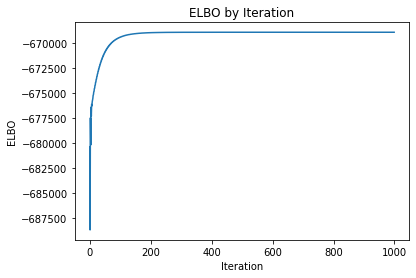

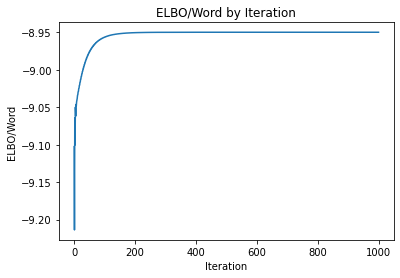

In [8]:
plt.plot(elbo_out)
plt.title('ELBO by Iteration')
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.show()

plt.plot([item/np.sum(tokenized_fed.values) for item in elbo_out])
plt.title('ELBO/Word by Iteration')
plt.xlabel('Iteration')
plt.ylabel('ELBO/Word')
plt.show()

Furthermore, the top words from each topic are generic and plausible. We have:

In [9]:
top_words = pd.DataFrame(q_eta.mean().T, 
                         columns=[f"topic_{item}" for item in range(1, 11)])
top_words['word'] = tokenized_fed.columns.to_list()

for i in range(1, 11):
  print("*" * 20)
  print(f"Topic {i}")
  word_head = top_words.\
    sort_values(f"topic_{i}", ascending=False)[['word', f"topic_{i}"]].\
      head().\
      reset_index(drop=True)
  print(word_head)

********************
Topic 1
           word   topic_1
0           new  0.011124
1          plan  0.007521
2           men  0.006814
3  constitution  0.004587
4           man  0.003920
********************
Topic 2
         word   topic_2
0     federal  0.015487
1        part  0.008293
2  particular  0.006832
3     without  0.005812
4     nations  0.005040
********************
Topic 3
          word   topic_3
0  legislature  0.007394
1        great  0.006841
2        force  0.006089
3       little  0.005477
4      general  0.005414
********************
Topic 4
       word   topic_4
0    people  0.013723
1        us  0.006228
2  national  0.005886
3     among  0.005066
4     first  0.004235
********************
Topic 5
           word   topic_5
0      congress  0.004567
1     authority  0.003757
2  constitution  0.003528
3    convention  0.003460
4        either  0.003260
********************
Topic 6
      word   topic_6
0  members  0.006382
1      two  0.004826
2     part  0.003665
3  f

## Problem 2: Analysis/Exploration

Using the model, for each essay assign it the most likely topic. For the undisputed papers, plot the histogram of this topic usage vs author.

In [55]:
#load authorship
authorship = pd.read_csv('https://raw.githubusercontent.com/slinderman/stats271sp2021/main/assignments/hw5/authorship.csv')
authorship.columns = ['text', 'author']
authorship.head()

,text,author
0,1,HAMILTON
1,2,JAY
2,3,JAY
3,4,JAY
4,5,JAY


First we note the most likely topics from each paper. 

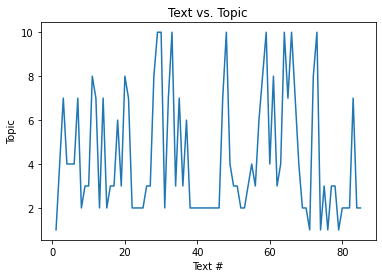

,text,author,probable_topic
0,1,HAMILTON,1
1,2,JAY,4
2,3,JAY,7
3,4,JAY,4
4,5,JAY,4
...,...,...,...
80,81,HAMILTON,2
81,82,HAMILTON,2
82,83,HAMILTON,7
83,84,HAMILTON,2


In [25]:
winners = []
data = tokenized_fed.values
for n in trange(data.shape[0]):
  winners.append(int(np.argmax(q_pi.mean()[n, :])) + 1)

authorship['probable_topic'] = winners
plt.plot(authorship.text, authorship.probable_topic)
plt.xlabel('Text #')
plt.ylabel('Topic')
plt.title('Text vs. Topic')
plt.show()

authorship

Next, we make the requested histogram of each author's probable topic distribution.

In [56]:
authorship_ = authorship.copy()
authorship_ = pd.concat([
  authorship_,
  pd.DataFrame(q_pi.mean(), columns=[f'p_topic_{i}' for i in range(1, 11)])
  ],
  axis=1
)
authorship_

,text,author,p_topic_1,p_topic_2,p_topic_3,p_topic_4,p_topic_5,p_topic_6,p_topic_7,p_topic_8,p_topic_9,p_topic_10
0,1,HAMILTON,0.173961,0.070233,0.128509,0.141432,0.033471,0.033991,0.123113,0.087400,0.079595,0.128295
1,2,JAY,0.088400,0.116588,0.084302,0.195915,0.034262,0.052748,0.109521,0.134093,0.037279,0.146894
2,3,JAY,0.055136,0.143888,0.131174,0.120845,0.019087,0.020968,0.214390,0.107098,0.112163,0.075251
3,4,JAY,0.115070,0.163036,0.090591,0.190159,0.020901,0.027865,0.106386,0.154703,0.034443,0.096846
4,5,JAY,0.076223,0.151255,0.106870,0.183738,0.022727,0.018464,0.143099,0.141648,0.010926,0.145049
...,...,...,...,...,...,...,...,...,...,...,...,...
80,81,HAMILTON,0.186148,0.237192,0.120416,0.027239,0.050993,0.017398,0.219719,0.035445,0.037344,0.068106
81,82,HAMILTON,0.145375,0.276369,0.133344,0.012972,0.029214,0.024912,0.242943,0.007327,0.032366,0.095179
82,83,HAMILTON,0.148837,0.134175,0.130647,0.067452,0.065170,0.005274,0.243876,0.129433,0.025200,0.049937
83,84,HAMILTON,0.116501,0.164718,0.102479,0.109042,0.075187,0.018409,0.130652,0.130352,0.055502,0.097158


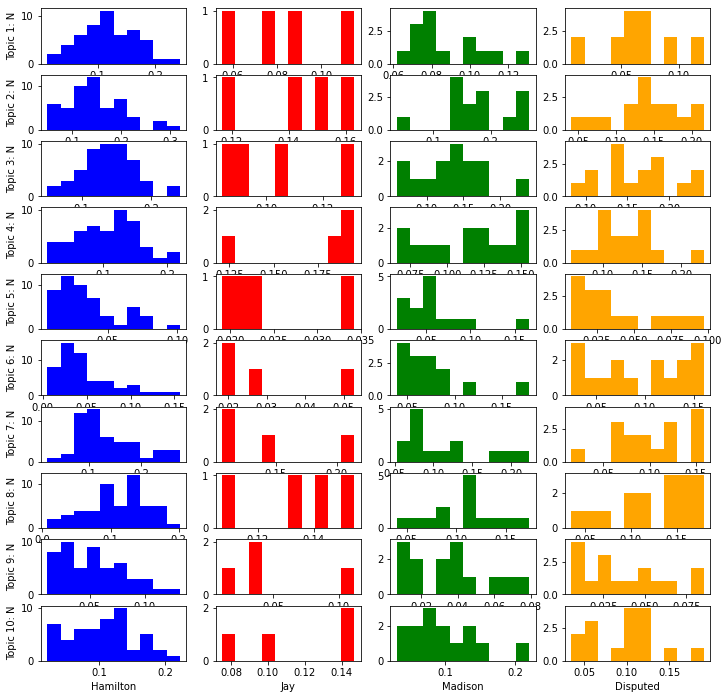

In [58]:
fig, axs = plt.subplots(10, 4, figsize=(12, 12))
for topic in range(1,11):
  axs[topic-1, 0].hist(authorship_.query('author == "HAMILTON"')[f"p_topic_{topic}"], color='blue')
  axs[topic-1, 0].set_ylabel(f"Topic {topic}: N")
  axs[topic-1, 1].hist(authorship_.query('author == "JAY"')[f"p_topic_{topic}"], color='red')
  axs[topic-1, 2].hist(authorship_.query('author == "MADISON"')[f"p_topic_{topic}"], color='green')
  axs[topic-1, 3].hist(authorship_.query('author == "DISPUTED"')[f"p_topic_{topic}"], color='orange')
axs[9, 0].set_xlabel('Hamilton')
axs[9, 1].set_xlabel('Jay')
axs[9, 2].set_xlabel('Madison')
axs[9, 3].set_xlabel('Disputed')
plt.show()

## Problem 3: Short Answer questions

### Part a)

Explain what approach you would take if you wanted to use LDA to help settle disputed authorship. How would you incorporate authorship by different authors into your model?

Two immediate options pop to mind. The first, and most simplistic, involves letting each author be their own "topic." That is, there would be $K=3$, one for Jay/Hamilton/Madison, and the assumption would be that each author would have their own political/governmental/constitutional interests, and their collective writing style about those interests would manifest itself as an all-encompassing "topic." Just as the "sports" section of a newspaper involves words relating to sports, or the "business" section involves more financial terminology, the "Hamilton" section would feature Hamilton's diction and interests, etc. 

Of course, by allowing the authors to hijack the topics, the model might also struggle to account for literal topics themselves -- i.e. it would distinguish (or at least attempt to) authors, but not the sub-categories they would write about. The above method would have no way of knowing that regardless of author, writing about judicial matters may increase the likelihood of certain words (i.e. court, justice, trial, bench, etc.), whereas writing about legislative matters may increase the likelihood of other words (congress, house, representative, etc.). In this way, the above model would fail to consider the fact that some subject matters -- regardless of author -- invoke certain terminology. To correct for this, in the model, one might want to add a second dimension to the $z$ variable, in effect making it a tuple of $\langle$author, political topic $\rangle$. Naturally, two $\eta$s and two $\pi$s -- one for author and one for political topic -- would be necessary as well. In this way, the model could view word choice as the product of both author and subject matter -- and their interaction -- and perhaps address the disputed texts. 
### Part b)

A shortcoming of LDA discussed in this class is the fact that the model is exchangeable (which is not a very reasonable assumption for essays). What would you do to address this shortcoming? In essence, how could you account for dependencies between words that are near each other in the essay?

One obvious issue is that this exchangeable structure fails to account for the ordering of words, and potential stylistic tendencies therein. For instance, Hamilton might be inclined to write something like (Federalist 83):

$$\textit{
"The force of this consideration is, however, diminished by others. The sheriff, who is the summoner of ordinary juries..."}$$

But Madison might have written:

$$\textit{
"However, the force of this consideration is diminished by others. The sheriff, who is the summoner of ordinary juries..."}$$

For the purposes of the model, this reversal (and more generally, the reversal of clauses) would be the same to the model. As such, it would lose important stylistic information. 

I see a couple of potential remedies here. First, we could concatenate phrases (i.e. "ordinary" and "juries" into "ordinary_juries", and treat them as their own word when appropriate. Similarly, we could treat opening-sentence "however"'s as different than mid-sentence "however"'s. In this way, phrasing might better be captured by our LDA model.

Alternatively, if we were really insistent on phrasing/ordering, we could scrap the LDA model and move to a Markov-chain approach. Each of the topics could still have its own "sub-chain" (i.e. square region of the transition matrix, with some positive probability of transitioning out to another topic), and we could proceed this way. This, however, might be much less computationally convenient than the LDA set forth above. 

# Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. If you're working in Colab, you can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF:
```
jupyter nbconvert --to pdf hw5_yourname.ipynb
```

**Dependencies:**

- `nbconvert`: If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```

**Upload** your .ipynb and .pdf files to Gradescope. 
